# ISM6562 Final
# Crashes
## https://catalog.data.gov/dataset/crash-reporting-drivers-data


## Start Spark Session

In [1]:
from pyspark.sql import SparkSession;
from pyspark.context import SparkContext;

# warehouse_location points to the default location for managed databases and tables
from os.path import abspath
warehouse_location = abspath('spark-warehouse')

spark = SparkSession \
    . builder \
    .master("local[*]") \
    .appName("Final") \
    .config("spark.sql.warehouse.dir", warehouse_location) \
    .enableHiveSupport() \
    .getOrCreate()

sc =spark.sparkContext
sc.setLogLevel("ERROR") # only display errors (not warnings)

# note: If you have multiple spark sessions running (like from a previous notebook you've run), 
# this spark session webUI will be on a different port than the default (4040). One way to 
# identify this part is with the following line. If there was only one spark session running, 
# this will be 4040. If it's higher, it means there are still other spark sesssions still running.
spark_session_port = spark.sparkContext.uiWebUrl.split(":")[-1]
print("Spark Session WebUI Port: " + spark_session_port)



23/11/09 00:03:05 WARN Utils: Your hostname, localhost.localdomain resolves to a loopback address: 127.0.0.1; using 10.21.12.4 instead (on interface eth0)
23/11/09 00:03:05 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/11/09 00:03:05 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Spark Session WebUI Port: 4040


In [2]:
spark

## Load Crash Data

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql.functions import col

## Use spark Sql to query relevant  from the raw table load into a formatted dataframe with some massaging on the columns

In [17]:
data = spark.sql("SELECT Report_Number\
               , CASE WHEN Driver_At_Fault = 'Yes' THEN 1 ELSE 0 END as Fault\
               , Weather\
               , Surface_Condition\
               , Light\
               , CASE WHEN Driver_Substance_Abuse in ('UNKNOWN','N/A','NONE DETECTED') THEN 'NONE' ELSE Driver_Substance_Abuse END as Substance_Abuse\
               FROM crashes WHERE Driver_At_Fault != 'Unknown'")
data = data.dropna()
data.show(5)

+-------------+-----+-------+-----------------+--------------+---------------+
|Report_Number|Fault|Weather|Surface_Condition|         Light|Substance_Abuse|
+-------------+-----+-------+-----------------+--------------+---------------+
|  MCP2874000K|    0|  SLEET|              ICE|DARK LIGHTS ON|            NaN|
|  MCP3228001Y|    1|  CLEAR|              DRY|      DAYLIGHT|           NONE|
|  MCP3003004G|    0|RAINING|              WET|DARK LIGHTS ON|           NONE|
|  MCP2195004Q|    0|RAINING|              WET|      DAYLIGHT|           NONE|
|  MCP1015001M|    1|RAINING|              WET|      DAYLIGHT|           NONE|
+-------------+-----+-------+-----------------+--------------+---------------+
only showing top 5 rows



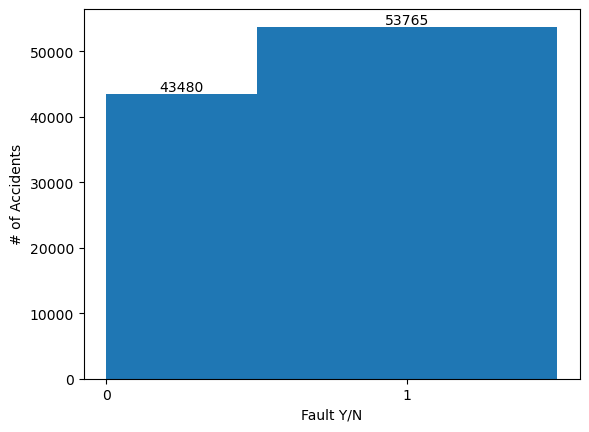

In [18]:
df2 = data.toPandas()
values, bins, bars = plt.hist(df2['Fault'], bins=[0,0.5,1.5])
plt.xlabel("Fault Y/N")
plt.ylabel("# of Accidents")
plt.xticks([0, 1])
plt.bar_label(bars)
plt.show()

In [19]:
train_data,test_data = data.randomSplit([0.75,0.25])

## Logistic Regression

In [20]:
# Import libraries
from pyspark.ml.classification import LogisticRegression, LinearSVC
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder, StandardScaler
from pyspark.ml import Pipeline

In [21]:
Weather_indexer                = StringIndexer(inputCol='Weather', outputCol='Weather_index', handleInvalid='keep')
Surface_Condition_indexer      = StringIndexer(inputCol='Surface_Condition', outputCol='Surface_Condition_index', handleInvalid='keep')
Light_indexer                  = StringIndexer(inputCol='Light', outputCol='Light_index', handleInvalid='keep')
Substance_Abuse_indexer        = StringIndexer(inputCol='Substance_Abuse', outputCol='Substance_Abuse_index', handleInvalid='keep')

In [22]:
data_encoder = OneHotEncoder(
    inputCols=[
        'Weather_index',
        'Surface_Condition_index',
        'Light_index',
        'Substance_Abuse_index'
    ],
     outputCols=[
        'Weather_vector',
        'Surface_Condition_vector',
        'Light_vector',
        'Substance_Abuse_vector'
     ],
    handleInvalid='keep'
)

In [23]:
assembler = VectorAssembler(
    inputCols=[
        'Weather_vector',
        'Surface_Condition_vector',
        'Light_vector',
        'Substance_Abuse_vector'
    ],
    outputCol = "features"
)

In [24]:
logit_model = LogisticRegression(labelCol='Fault')

In [25]:
logit_pipe = Pipeline(
    stages=[
        Weather_indexer,
        Surface_Condition_indexer,
        Light_indexer, 
        Substance_Abuse_indexer, 
        data_encoder,
        assembler,
        logit_model
    ]
)

In [26]:
fit_model = logit_pipe.fit(train_data)
logit_results = fit_model.transform(test_data)

In [27]:
logit_results.select(['Fault','prediction']).show()

+-----+----------+
|Fault|prediction|
+-----+----------+
|    0|       1.0|
|    0|       1.0|
|    1|       1.0|
|    0|       0.0|
|    0|       1.0|
|    0|       1.0|
|    1|       1.0|
|    1|       1.0|
|    1|       1.0|
|    1|       1.0|
|    1|       1.0|
|    0|       1.0|
|    0|       1.0|
|    1|       1.0|
|    1|       1.0|
|    1|       1.0|
|    1|       1.0|
|    1|       1.0|
|    1|       1.0|
|    0|       1.0|
+-----+----------+
only showing top 20 rows



## Evaluate Logistic Regression

In [28]:
nf = logit_results.filter(col("prediction")==0).count()
f = logit_results.filter(col("prediction")==1).count()

print(f"Precited Non Fault: {nf}")
print(f"Precited Fault: {f}")

Precited Non Fault: 3268
Precited Fault: 21065


In [29]:
from pyspark.ml.evaluation import RegressionEvaluator
MAE_evaluator = RegressionEvaluator(predictionCol="prediction",labelCol="Fault", metricName="mae")
mae = MAE_evaluator.evaluate(logit_results)
print(f"Mean Absolute Error: {mae}")


Mean Absolute Error: 0.4464718694776641


In [30]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

AUC_evaluator = BinaryClassificationEvaluator(rawPredictionCol='prediction',labelCol='Fault',metricName='areaUnderROC')
AUC = AUC_evaluator.evaluate(logit_results)

AUPR_evaluator = BinaryClassificationEvaluator(rawPredictionCol='prediction',labelCol='Fault',metricName='areaUnderPR')
AUPR = AUPR_evaluator.evaluate(logit_results)

print(f"Area Under Curve: {AUC}")
print(f"Area Under PR Curve: {AUPR}")

Area Under Curve: 0.5159907802496241
Area Under PR Curve: 0.5601450143042579


In [31]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
ACC_evaluator = MulticlassClassificationEvaluator(labelCol="Fault",predictionCol="prediction",metricName="accuracy")
Accuracy = ACC_evaluator.evaluate(logit_results)
print(Accuracy)

0.553528130522336


In [32]:
from sklearn.metrics import confusion_matrix

y_true = logit_results.select("Fault").toPandas()
 
y_pred = logit_results.select("prediction").toPandas()
 
cnf_matrix = confusion_matrix(y_true, y_pred)

print(cnf_matrix)



[[ 1658  9254]
 [ 1610 11811]]


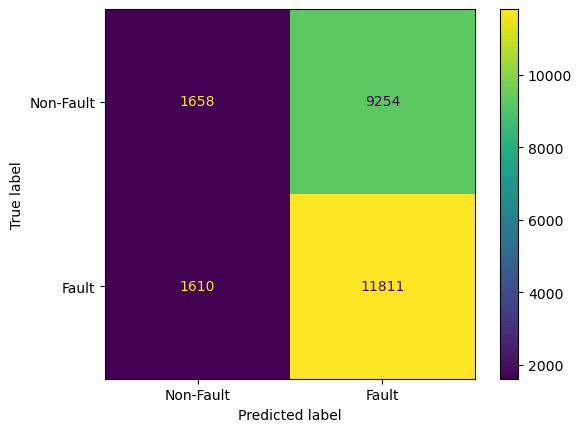

In [33]:
from sklearn.metrics import ConfusionMatrixDisplay

 
color = 'white'
disp = ConfusionMatrixDisplay(confusion_matrix=cnf_matrix, display_labels = ['Non-Fault', 'Fault'])
disp.plot()
plt.show()

In [34]:


tn = cnf_matrix[0][0]
fp = cnf_matrix[0][1]
fn = cnf_matrix[1][0]
tp = cnf_matrix[1][1]

accuracy = (tp+tn)/(tp+tn+fp+fn)
precision = tp/(tp+fp)
recall = tp/(tp+fn)
f1_score = 2*(precision*recall)/(precision+recall)



print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1_score:.2f}")



Accuracy: 0.55
Precision: 0.56
Recall: 0.88
F1 Score: 0.68


## SVC

In [35]:
assembler = VectorAssembler(
    inputCols=[
        'Weather_index',
        'Surface_Condition_index',
        'Light_index',
        'Substance_Abuse_index'
    ],
    outputCol = "unscaled_features"
)

In [36]:
scaler = StandardScaler(inputCol= "unscaled_features", outputCol = "features")

In [37]:
svc_model = LinearSVC(labelCol='Fault')

In [38]:
svc_pipe = Pipeline(
    stages=[
        Weather_indexer,
        Surface_Condition_indexer,
        Light_indexer, 
        Substance_Abuse_indexer, 
        assembler,
        scaler,
        svc_model
    ]
)

In [39]:
svc_fit_model = svc_pipe.fit(train_data)

In [40]:
svc_results = svc_fit_model.transform(test_data)
svc_results.select(['Fault','prediction']).show()

+-----+----------+
|Fault|prediction|
+-----+----------+
|    0|       1.0|
|    0|       1.0|
|    1|       1.0|
|    0|       1.0|
|    0|       1.0|
|    0|       1.0|
|    1|       1.0|
|    1|       1.0|
|    1|       1.0|
|    1|       1.0|
|    1|       1.0|
|    0|       1.0|
|    0|       1.0|
|    1|       1.0|
|    1|       1.0|
|    1|       1.0|
|    1|       1.0|
|    1|       1.0|
|    1|       1.0|
|    0|       1.0|
+-----+----------+
only showing top 20 rows



In [41]:
from pyspark.sql.functions import col
nf = svc_results.filter(col("prediction")==0).count()
f = svc_results.filter(col("prediction")==1).count()

print(f"Precited Non Fault: {nf}")
print(f"Precited Fault: {f}")

Precited Non Fault: 0
Precited Fault: 24333


In [42]:
from pyspark.ml.evaluation import RegressionEvaluator
MAE_evaluator = RegressionEvaluator(predictionCol="prediction",labelCol="Fault", metricName="mae")
mae = MAE_evaluator.evaluate(svc_results)
print(f"Mean Absolute Error: {mae}")


Mean Absolute Error: 0.44844449923971563


In [43]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

AUC_evaluator = BinaryClassificationEvaluator(rawPredictionCol='prediction',labelCol='Fault',metricName='areaUnderROC')
AUC = AUC_evaluator.evaluate(svc_results)

AUPR_evaluator = BinaryClassificationEvaluator(rawPredictionCol='prediction',labelCol='Fault',metricName='areaUnderPR')
AUPR = AUPR_evaluator.evaluate(svc_results)

print(f"Area Under Curve: {AUC}")
print(f"Area Under PR Curve: {AUPR}")

Area Under Curve: 0.5
Area Under PR Curve: 0.5515555007602844


In [44]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
ACC_evaluator = MulticlassClassificationEvaluator(labelCol="Fault",predictionCol="prediction",metricName="accuracy")
Accuracy = ACC_evaluator.evaluate(svc_results)
print(Accuracy)

0.5515555007602844


In [45]:
from sklearn.metrics import confusion_matrix

y_true = svc_results.select("Fault").toPandas()
 
y_pred = svc_results.select("prediction").toPandas()
 
cnf_matrix = confusion_matrix(y_true, y_pred)

print(cnf_matrix)



[[    0 10912]
 [    0 13421]]


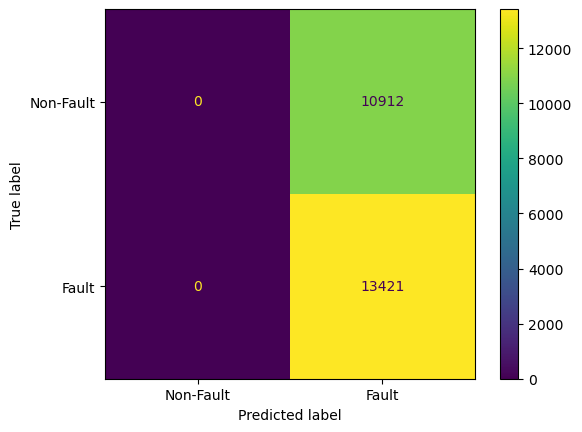

In [46]:
color = 'white'
disp = ConfusionMatrixDisplay(confusion_matrix=cnf_matrix, display_labels = ['Non-Fault', 'Fault'])
disp.plot()
plt.show()

In [47]:


tn = cnf_matrix[0][0]
fp = cnf_matrix[0][1]
fn = cnf_matrix[1][0]
tp = cnf_matrix[1][1]

accuracy = (tp+tn)/(tp+tn+fp+fn)
precision = tp/(tp+fp)
recall = tp/(tp+fn)
f1_score = 2*(precision*recall)/(precision+recall)



print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1_score:.2f}")



Accuracy: 0.55
Precision: 0.55
Recall: 1.00
F1 Score: 0.71
